In [1]:
from decimal import Decimal # for filenames

import pdb #Equivalent of keyboard in MATLAB, just add "pdb.set_trace()"

import os
import sys

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
from Utilities.get_image_data import load_data
from Utilities.form_train_val_test_batches import form_train_val_test_batches
from Utilities.NN_FC_layerwise import FCLayerwise
from Utilities.NN_FC_layerwise_new import FCLayerwise_new
from Utilities.NETW import Final
from Utilities.Net import Final_Network
from Utilities.Net_new import Final_Network_ALGO_II
from Utilities.create_data import create_new
from Utilities.create_data_multiply import create_new_multiply
from Utilities.loss_and_accuracies import data_loss_classification, data_loss_regression
from Utilities.manifold_regularization import manifold_classification
from Utilities.manifold_regularization_new import manifold_classification_new
from Utilities.optimize_layerwise import optimize
from Utilities.optimize_step_II import optimize_step
from Utilities.additive_output import net_output 
from Utilities.plot_and_save_figures_layerwise import plot_fig
from joblib import Parallel, delayed
import multiprocessing
import random

In [4]:
###############################################################################
#                       HyperParameters and RunOptions                        #
###############################################################################
class Hyperparameters:
    max_hidden_layers = 10 # For this architecture, need at least 2. One for the mapping to the feature space, one as a trainable hidden layer. EXCLUDES MAPPING BACK TO DATA SPACE
    num_hidden_nodes  = 100
    activation        = 'elu'
    classification_act= 'linear'
    regularization    = 0.001
    manifold          = 0.001
    node_TOL          = 1e-4
    error_TOL         = 1e-4
    batch_size        = 70
    num_epochs        = 5000
    
    num_networks      = 6
    

In [5]:
class Hyperparameters_new:
    max_hidden_layers = 3 # For this architecture, need at least 2. One for the mapping to the feature space, one as a trainable hidden layer. EXCLUDES MAPPING BACK TO DATA SPACE
    num_hidden_nodes  = 5
    activation        = 'elu'
    classification_act= 'linear'
    regularization    = 0.000
    manifold          = 0.000
    node_TOL          = 1e-4
    error_TOL         = 1e-4
    batch_size        = 100
    num_epochs        = 100

In [6]:
class RunOptions:
    def __init__(self):    
        #=== Choose Which GPU to Use ===#
        self.which_gpu = '1'
        
        #=== Use L_1 Regularization ===#
        self.use_L1 = 1
        
        #=== Choose Data Set ===#
        self.data_MNIST = 0
        self.data_CIFAR10 = 0 
        self.data_CIFAR100 = 0
        self.data_regression=1
        
        #=== Random Seed ===#
        self.random_seed = 1234


In [7]:
###############################################################################
#                                 File Paths                                  #
###############################################################################         
class FilePaths():    
    def __init__(self, hyperp, run_options):  
        #=== Declaring File Name Components ===# 
        self.NN_type = 'FC'
        if run_options.data_MNIST == 1:
            self.dataset = 'MNIST'
        if run_options.data_CIFAR10 == 1:
            self.dataset = 'CIFAR10'
        if run_options.data_CIFAR100 == 1:
            self.dataset = 'CIFAR100'
        if run_options.data_regression == 1:
            self.dataset = 'Abalone'
        if hyperp.regularization >= 1:
            hyperp.regularization = int(hyperp.regularization)
            regularization_string = str(hyperp.regularization)
        else:
            regularization_string = str(hyperp.regularization)
            regularization_string = 'pt' + regularization_string[2:]                        
        node_TOL_string = str('%.2e' %Decimal(hyperp.node_TOL))
        node_TOL_string = node_TOL_string[-1]
        error_TOL_string = str('%.2e' %Decimal(hyperp.error_TOL))
        error_TOL_string = error_TOL_string[-1]
        
        #=== File Name ===#
        if run_options.use_L1 == 0:
            self.filename = self.dataset + '_' + self.NN_type + '_mhl%d_hl%d_eTOL%s_b%d_e%d' %(hyperp.max_hidden_layers, hyperp.num_hidden_nodes, error_TOL_string, hyperp.batch_size, hyperp.num_epochs)
        else:
            self.filename = self.dataset + '_' + self.NN_type + '_L1_mhl%d_hl%d_r%s_nTOL%s_eTOL%s_b%d_e%d' %(hyperp.max_hidden_layers, hyperp.num_hidden_nodes, regularization_string, node_TOL_string, error_TOL_string, hyperp.batch_size, hyperp.num_epochs)

        #=== Saving Trained Neural Network and Tensorboard ===#
        #self.NN_savefile_directory = 'C:/Users/Chandradut/Desktop/Sparse training/Trained_NNs/' + self.filename # Since we need to save four different types of files to save a neural network model, we need to create a new folder for each model
        self.NN_savefile_directory =  self.filename
        self.NN_savefile_name = self.NN_savefile_directory + '/' + self.filename # The file path and name for the four files
        #self.tensorboard_directory = 'C:/Users/Chandradut/Desktop/Sparse training/Tensorboard/' + self.filename

###############################################################################



2022-04-23 23:15:58.467702: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-23 23:15:58.499924: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2593550000 Hz
2022-04-23 23:15:58.501816: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55ff234d0230 executing computations on platform Host. Devices:
2022-04-23 23:15:58.501861: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version
2022-04-23 23:15:58.504110: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


ListWrapper([13, 100, 100, 1])
Beginning Training
            Epoch 0            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Model: "fc_layerwise"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
W2 (Dense)                   multiple                  10100     
_________________________________________________________________
W3 (Dense)                   multiple                  10100     
_________________________________________________________________
W4 (Dense)                   multiple                  10100     
_________________________________________________________________
W5 (Dense)                   multiple                  10100     
_________________________________________________________________
W6 (Dense)                   multiple                  10100     
__________________________________________

Time per Batch: 0.44
Time per Epoch: 2.44

Training Set: Loss: 2.722e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 33.805

Previous Layer Relative # of 0s: 0.0000000

            Epoch 15            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.41

Training Set: Loss: 2.651e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 33.033

Previous Layer Relative # of 0s: 0.0000000

            Epoch 16            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 2.580e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 32.269

Previous Layer Relative # of 0s: 0.000

Time per Epoch: 2.69

Training Set: Loss: 2.079e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 27.282

Previous Layer Relative # of 0s: 0.0000000

            Epoch 33            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.52
Time per Epoch: 2.68

Training Set: Loss: 2.112e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 26.975

Previous Layer Relative # of 0s: 0.0000000

            Epoch 34            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.51
Time per Epoch: 2.78

Training Set: Loss: 2.121e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 26.374

Previous Layer Relative # of 0s: 0.0000000

            Epo

Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 1.818e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 25.313

Previous Layer Relative # of 0s: 0.0000000

            Epoch 52            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.45
Time per Epoch: 2.46

Training Set: Loss: 1.742e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 25.221

Previous Layer Relative # of 0s: 0.0000000

            Epoch 53            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.46
Time per Epoch: 2.62

Training Set: Loss: 1.790e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 24.931

Previous Layer Relative # of 0s: 0.000

Time per Epoch: 2.40

Training Set: Loss: 1.551e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 21.962

Previous Layer Relative # of 0s: 0.0000000

            Epoch 70            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 1.708e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 21.518

Previous Layer Relative # of 0s: 0.0000000

            Epoch 71            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.48
Time per Epoch: 2.49

Training Set: Loss: 1.558e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 21.658

Previous Layer Relative # of 0s: 0.0000000

            Epo

Time per Batch: 0.44
Time per Epoch: 2.45

Training Set: Loss: 1.281e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 21.904

Previous Layer Relative # of 0s: 0.0000000

            Epoch 89            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.46
Time per Epoch: 2.41

Training Set: Loss: 1.305e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 21.217

Previous Layer Relative # of 0s: 0.0000000

            Epoch 90            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.51
Time per Epoch: 2.55

Training Set: Loss: 1.353e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 21.350

Previous Layer Relative # of 0s: 0.000

Time per Batch: 0.50
Time per Epoch: 2.65

Training Set: Loss: 1.200e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 19.961

Previous Layer Relative # of 0s: 0.0000000

            Epoch 107            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.51
Time per Epoch: 2.55

Training Set: Loss: 1.190e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.966

Previous Layer Relative # of 0s: 0.0000000

            Epoch 108            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.45
Time per Epoch: 2.43

Training Set: Loss: 1.198e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 19.685

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.44
Time per Epoch: 2.44

Training Set: Loss: 1.168e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 20.197

Previous Layer Relative # of 0s: 0.0000000

            Epoch 125            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.41

Training Set: Loss: 1.212e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.754

Previous Layer Relative # of 0s: 0.0000000

            Epoch 126            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.43

Training Set: Loss: 1.181e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 19.374

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.48
Time per Epoch: 2.52

Training Set: Loss: 1.250e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 19.033

Previous Layer Relative # of 0s: 0.0000000

            Epoch 143            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.44

Training Set: Loss: 1.138e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 21.288

Previous Layer Relative # of 0s: 0.0000000

            Epoch 144            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.45
Time per Epoch: 2.42

Training Set: Loss: 1.186e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.468

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.45
Time per Epoch: 2.50

Training Set: Loss: 1.097e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.160

Previous Layer Relative # of 0s: 0.0000000

            Epoch 161            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.46
Time per Epoch: 2.54

Training Set: Loss: 1.192e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.596

Previous Layer Relative # of 0s: 0.0000000

            Epoch 162            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.45
Time per Epoch: 2.43

Training Set: Loss: 1.081e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.061

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.45
Time per Epoch: 2.39

Training Set: Loss: 1.081e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.243

Previous Layer Relative # of 0s: 0.0000000

            Epoch 179            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.45
Time per Epoch: 2.40

Training Set: Loss: 1.106e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.362

Previous Layer Relative # of 0s: 0.0000000

            Epoch 180            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 1.127e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.520

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.47
Time per Epoch: 2.45

Training Set: Loss: 1.066e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.101

Previous Layer Relative # of 0s: 0.0000000

            Epoch 197            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.45
Time per Epoch: 2.43

Training Set: Loss: 1.061e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.574

Previous Layer Relative # of 0s: 0.0000000

            Epoch 198            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.47
Time per Epoch: 2.44

Training Set: Loss: 1.087e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.055

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.46
Time per Epoch: 2.60

Training Set: Loss: 1.038e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.504

Previous Layer Relative # of 0s: 0.0000000

            Epoch 215            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.46
Time per Epoch: 2.56

Training Set: Loss: 1.044e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.356

Previous Layer Relative # of 0s: 0.0000000

            Epoch 216            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.51
Time per Epoch: 2.60

Training Set: Loss: 1.068e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.120

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.44
Time per Epoch: 2.44

Training Set: Loss: 1.178e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.267

Previous Layer Relative # of 0s: 0.0000000

            Epoch 233            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 1.026e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.794

Previous Layer Relative # of 0s: 0.0000000

            Epoch 234            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 1.029e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.022

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.44
Time per Epoch: 2.45

Training Set: Loss: 1.029e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.333

Previous Layer Relative # of 0s: 0.0000000

            Epoch 251            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.50
Time per Epoch: 2.60

Training Set: Loss: 1.002e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 19.049

Previous Layer Relative # of 0s: 0.0000000

            Epoch 252            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.46
Time per Epoch: 2.51

Training Set: Loss: 9.905e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.383

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.45
Time per Epoch: 2.41

Training Set: Loss: 9.800e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.186

Previous Layer Relative # of 0s: 0.0000000

            Epoch 269            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.45
Time per Epoch: 2.44

Training Set: Loss: 1.033e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.968

Previous Layer Relative # of 0s: 0.0000000

            Epoch 270            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.50
Time per Epoch: 2.48

Training Set: Loss: 1.084e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.897

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 9.148e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.606

Previous Layer Relative # of 0s: 0.0000000

            Epoch 287            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.45

Training Set: Loss: 1.006e+01, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.967

Previous Layer Relative # of 0s: 0.0000000

            Epoch 288            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 9.896e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.863

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 9.280e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.883

Previous Layer Relative # of 0s: 0.0000000

            Epoch 305            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.38

Training Set: Loss: 9.444e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.790

Previous Layer Relative # of 0s: 0.0000000

            Epoch 306            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.37

Training Set: Loss: 9.504e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.375

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.48
Time per Epoch: 2.46

Training Set: Loss: 9.099e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.886

Previous Layer Relative # of 0s: 0.0000000

            Epoch 323            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.39

Training Set: Loss: 9.022e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.441

Previous Layer Relative # of 0s: 0.0000000

            Epoch 324            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.49
Time per Epoch: 2.44

Training Set: Loss: 8.698e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.317

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.46
Time per Epoch: 2.45

Training Set: Loss: 9.322e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.324

Previous Layer Relative # of 0s: 0.0000000

            Epoch 341            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.49
Time per Epoch: 2.46

Training Set: Loss: 9.063e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.528

Previous Layer Relative # of 0s: 0.0000000

            Epoch 342            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 8.797e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.542

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 8.573e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.671

Previous Layer Relative # of 0s: 0.0000000

            Epoch 359            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.48
Time per Epoch: 2.54

Training Set: Loss: 8.893e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.807

Previous Layer Relative # of 0s: 0.0000000

            Epoch 360            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.52
Time per Epoch: 2.47

Training Set: Loss: 8.939e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.598

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.49
Time per Epoch: 2.45

Training Set: Loss: 8.878e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.063

Previous Layer Relative # of 0s: 0.0000000

            Epoch 377            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.60

Training Set: Loss: 8.384e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.742

Previous Layer Relative # of 0s: 0.0000000

            Epoch 378            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.47
Time per Epoch: 2.49

Training Set: Loss: 8.555e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.967

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.44
Time per Epoch: 2.50

Training Set: Loss: 8.672e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.536

Previous Layer Relative # of 0s: 0.0000000

            Epoch 395            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.45
Time per Epoch: 2.39

Training Set: Loss: 8.170e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.065

Previous Layer Relative # of 0s: 0.0000000

            Epoch 396            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.51

Training Set: Loss: 8.172e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.138

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.45
Time per Epoch: 2.38

Training Set: Loss: 8.379e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.441

Previous Layer Relative # of 0s: 0.0000000

            Epoch 413            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 8.629e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.317

Previous Layer Relative # of 0s: 0.0000000

            Epoch 414            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 8.566e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.875

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 8.811e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.127

Previous Layer Relative # of 0s: 0.0000000

            Epoch 431            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.38

Training Set: Loss: 8.077e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.206

Previous Layer Relative # of 0s: 0.0000000

            Epoch 432            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.36

Training Set: Loss: 8.263e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.167

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.44
Time per Epoch: 2.41

Training Set: Loss: 8.577e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.866

Previous Layer Relative # of 0s: 0.0000000

            Epoch 449            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.36

Training Set: Loss: 8.184e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.780

Previous Layer Relative # of 0s: 0.0000000

            Epoch 450            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.44

Training Set: Loss: 8.244e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.072

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.48
Time per Epoch: 2.42

Training Set: Loss: 8.135e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.615

Previous Layer Relative # of 0s: 0.0000000

            Epoch 467            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 7.813e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.532

Previous Layer Relative # of 0s: 0.0000000

            Epoch 468            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.49
Time per Epoch: 2.41

Training Set: Loss: 8.442e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.609

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.47
Time per Epoch: 2.35

Training Set: Loss: 8.013e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.056

Previous Layer Relative # of 0s: 0.0000000

            Epoch 485            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 7.542e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.724

Previous Layer Relative # of 0s: 0.0000000

            Epoch 486            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.46
Time per Epoch: 2.36

Training Set: Loss: 8.257e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.608

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.43
Time per Epoch: 2.38

Training Set: Loss: 7.843e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.442

Previous Layer Relative # of 0s: 0.0000000

            Epoch 503            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 8.003e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.263

Previous Layer Relative # of 0s: 0.0000000

            Epoch 504            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.45
Time per Epoch: 2.38

Training Set: Loss: 7.809e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.985

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.44
Time per Epoch: 2.44

Training Set: Loss: 7.507e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.310

Previous Layer Relative # of 0s: 0.0000000

            Epoch 521            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.46
Time per Epoch: 2.48

Training Set: Loss: 7.594e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.257

Previous Layer Relative # of 0s: 0.0000000

            Epoch 522            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 7.780e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.675

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.45
Time per Epoch: 2.39

Training Set: Loss: 7.449e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.777

Previous Layer Relative # of 0s: 0.0000000

            Epoch 539            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 7.652e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.527

Previous Layer Relative # of 0s: 0.0000000

            Epoch 540            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 7.738e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.961

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 7.673e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.330

Previous Layer Relative # of 0s: 0.0000000

            Epoch 557            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 7.558e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.550

Previous Layer Relative # of 0s: 0.0000000

            Epoch 558            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 8.261e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.345

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 7.906e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 11.930

Previous Layer Relative # of 0s: 0.0000000

            Epoch 575            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 8.195e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 11.756

Previous Layer Relative # of 0s: 0.0000000

            Epoch 576            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.33

Training Set: Loss: 7.475e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.856

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.44
Time per Epoch: 2.33

Training Set: Loss: 7.407e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.949

Previous Layer Relative # of 0s: 0.0000000

            Epoch 593            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.41

Training Set: Loss: 8.034e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.296

Previous Layer Relative # of 0s: 0.0000000

            Epoch 594            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.45

Training Set: Loss: 7.588e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.541

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.46
Time per Epoch: 2.41

Training Set: Loss: 7.316e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.247

Previous Layer Relative # of 0s: 0.0000000

            Epoch 611            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.40

Training Set: Loss: 6.847e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.001

Previous Layer Relative # of 0s: 0.0000000

            Epoch 612            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.43

Training Set: Loss: 7.585e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.592

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.43
Time per Epoch: 2.34

Training Set: Loss: 7.193e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 11.637

Previous Layer Relative # of 0s: 0.0000000

            Epoch 629            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.41

Training Set: Loss: 7.187e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.167

Previous Layer Relative # of 0s: 0.0000000

            Epoch 630            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.43

Training Set: Loss: 7.117e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 11.257

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 7.329e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 11.820

Previous Layer Relative # of 0s: 0.0000000

            Epoch 647            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.37

Training Set: Loss: 7.513e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 11.807

Previous Layer Relative # of 0s: 0.0000000

            Epoch 648            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 8.023e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.002

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 7.098e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 11.384

Previous Layer Relative # of 0s: 0.0000000

            Epoch 665            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 7.359e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 11.241

Previous Layer Relative # of 0s: 0.0000000

            Epoch 666            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 6.979e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 11.810

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 6.774e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.312

Previous Layer Relative # of 0s: 0.0000000

            Epoch 683            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.47
Time per Epoch: 2.37

Training Set: Loss: 6.871e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.391

Previous Layer Relative # of 0s: 0.0000000

            Epoch 684            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 7.131e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.823

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 6.806e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 11.050

Previous Layer Relative # of 0s: 0.0000000

            Epoch 701            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.36

Training Set: Loss: 6.440e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 11.070

Previous Layer Relative # of 0s: 0.0000000

            Epoch 702            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.41

Training Set: Loss: 6.643e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 10.970

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.43
Time per Epoch: 2.35

Training Set: Loss: 6.671e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 11.238

Previous Layer Relative # of 0s: 0.0000000

            Epoch 719            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 6.621e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 11.121

Previous Layer Relative # of 0s: 0.0000000

            Epoch 720            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.40

Training Set: Loss: 6.647e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 11.409

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 6.724e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 11.669

Previous Layer Relative # of 0s: 0.0000000

            Epoch 737            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.38

Training Set: Loss: 6.257e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.603

Previous Layer Relative # of 0s: 0.0000000

            Epoch 738            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 6.939e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.312

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.44
Time per Epoch: 2.33

Training Set: Loss: 6.141e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.477

Previous Layer Relative # of 0s: 0.0000000

            Epoch 755            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 6.259e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.750

Previous Layer Relative # of 0s: 0.0000000

            Epoch 756            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.35

Training Set: Loss: 6.559e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.759

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.51
Time per Epoch: 2.77

Training Set: Loss: 6.273e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 10.936

Previous Layer Relative # of 0s: 0.0000000

            Epoch 773            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 6.487e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 11.186

Previous Layer Relative # of 0s: 0.0000000

            Epoch 774            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.45

Training Set: Loss: 6.166e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 10.763

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.48
Time per Epoch: 2.41

Training Set: Loss: 6.475e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.167

Previous Layer Relative # of 0s: 0.0000000

            Epoch 791            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.37

Training Set: Loss: 6.158e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 11.792

Previous Layer Relative # of 0s: 0.0000000

            Epoch 792            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.40

Training Set: Loss: 6.264e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.100

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.43
Time per Epoch: 2.34

Training Set: Loss: 5.909e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 10.904

Previous Layer Relative # of 0s: 0.0000000

            Epoch 809            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.43

Training Set: Loss: 6.135e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 9.543

Previous Layer Relative # of 0s: 0.0000000

            Epoch 810            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.45

Training Set: Loss: 7.129e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 10.529

Previous Layer Relative # of 0s: 0.00

Time per Batch: 0.43
Time per Epoch: 2.33

Training Set: Loss: 5.874e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 10.169

Previous Layer Relative # of 0s: 0.0000000

            Epoch 827            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.46

Training Set: Loss: 5.897e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 9.764

Previous Layer Relative # of 0s: 0.0000000

            Epoch 828            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 6.590e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 9.812

Previous Layer Relative # of 0s: 0.000

Time per Batch: 0.47
Time per Epoch: 2.40

Training Set: Loss: 6.048e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 10.424

Previous Layer Relative # of 0s: 0.0000000

            Epoch 845            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 5.835e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 10.568

Previous Layer Relative # of 0s: 0.0000000

            Epoch 846            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.41

Training Set: Loss: 5.687e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 10.429

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.43
Time per Epoch: 2.35

Training Set: Loss: 5.464e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.349

Previous Layer Relative # of 0s: 0.0000000

            Epoch 863            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 5.675e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.790

Previous Layer Relative # of 0s: 0.0000000

            Epoch 864            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 5.435e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 10.734

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.43
Time per Epoch: 2.35

Training Set: Loss: 6.217e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 9.803

Previous Layer Relative # of 0s: 0.0000000

            Epoch 881            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.33

Training Set: Loss: 5.924e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 10.177

Previous Layer Relative # of 0s: 0.0000000

            Epoch 882            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 5.311e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 10.616

Previous Layer Relative # of 0s: 0.00

Time per Batch: 0.44
Time per Epoch: 2.33

Training Set: Loss: 5.667e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 10.406

Previous Layer Relative # of 0s: 0.0000000

            Epoch 899            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 5.751e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 9.782

Previous Layer Relative # of 0s: 0.0000000

            Epoch 900            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.41

Training Set: Loss: 6.046e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 9.760

Previous Layer Relative # of 0s: 0.000

Time per Batch: 0.44
Time per Epoch: 2.46

Training Set: Loss: 5.178e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 11.724

Previous Layer Relative # of 0s: 0.0000000

            Epoch 917            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.46

Training Set: Loss: 5.140e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.151

Previous Layer Relative # of 0s: 0.0000000

            Epoch 918            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 5.030e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 11.678

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 5.417e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 10.062

Previous Layer Relative # of 0s: 0.0000000

            Epoch 935            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 5.639e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 10.194

Previous Layer Relative # of 0s: 0.0000000

            Epoch 936            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.47

Training Set: Loss: 5.134e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 10.076

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.43
Time per Epoch: 2.39

Training Set: Loss: 5.131e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 11.723

Previous Layer Relative # of 0s: 0.0000000

            Epoch 953            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.38

Training Set: Loss: 5.290e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 10.849

Previous Layer Relative # of 0s: 0.0000000

            Epoch 954            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 4.822e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 10.148

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.43
Time per Epoch: 2.39

Training Set: Loss: 5.331e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 10.570

Previous Layer Relative # of 0s: 0.0000000

            Epoch 971            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.37

Training Set: Loss: 4.963e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.016

Previous Layer Relative # of 0s: 0.0000000

            Epoch 972            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 4.855e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 10.155

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 4.878e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 10.966

Previous Layer Relative # of 0s: 0.0000000

            Epoch 989            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.44

Training Set: Loss: 5.054e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.133

Previous Layer Relative # of 0s: 0.0000000

            Epoch 990            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 4.956e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.741

Previous Layer Relative # of 0s: 0.0

Time per Batch: 0.48
Time per Epoch: 2.41

Training Set: Loss: 4.909e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 11.637

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1007            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.41

Training Set: Loss: 4.702e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.786

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1008            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.45
Time per Epoch: 2.38

Training Set: Loss: 4.922e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.239

Previous Layer Relative # of 0s: 0

Time per Batch: 0.43
Time per Epoch: 2.37

Training Set: Loss: 4.568e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.181

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1025            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 4.955e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.999

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1026            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.40

Training Set: Loss: 4.734e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.085

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 4.908e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.194

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1043            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 4.559e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.640

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1044            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 5.174e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 11.811

Previous Layer Relative # of 0s: 0

Time per Batch: 0.48
Time per Epoch: 2.40

Training Set: Loss: 4.610e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.905

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1061            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.44

Training Set: Loss: 4.225e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 11.810

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1062            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.41

Training Set: Loss: 4.548e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 10.501

Previous Layer Relative # of 0s: 0

Time per Batch: 0.43
Time per Epoch: 2.34

Training Set: Loss: 5.324e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 11.792

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1079            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 4.472e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.579

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1080            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.32

Training Set: Loss: 4.476e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 11.610

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 4.391e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.129

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1097            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.45

Training Set: Loss: 4.479e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.618

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1098            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.37

Training Set: Loss: 4.377e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.136

Previous Layer Relative # of 0s: 0

Time per Batch: 0.43
Time per Epoch: 2.43

Training Set: Loss: 4.731e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 11.106

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1115            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.45

Training Set: Loss: 4.862e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 10.859

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1116            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 4.583e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 11.633

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.50

Training Set: Loss: 4.168e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.729

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1133            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.48
Time per Epoch: 2.46

Training Set: Loss: 4.924e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.405

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1134            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 4.476e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.718

Previous Layer Relative # of 0s: 0

Time per Batch: 0.43
Time per Epoch: 2.44

Training Set: Loss: 5.005e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 11.043

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1151            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.36

Training Set: Loss: 4.529e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 11.168

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1152            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.47

Training Set: Loss: 4.644e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 11.160

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 4.566e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.554

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1169            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.43

Training Set: Loss: 4.496e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 11.825

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1170            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 4.250e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 11.603

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 4.226e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 10.886

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1187            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.40

Training Set: Loss: 4.215e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 11.494

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1188            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.47

Training Set: Loss: 4.144e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 10.982

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.45

Training Set: Loss: 4.265e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 11.930

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1205            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.40

Training Set: Loss: 4.380e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 11.534

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1206            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.47
Time per Epoch: 2.42

Training Set: Loss: 3.979e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.117

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 4.146e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.229

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1223            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.46

Training Set: Loss: 3.829e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.809

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1224            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.38

Training Set: Loss: 4.072e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.573

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.41

Training Set: Loss: 4.594e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 11.990

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1241            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.39

Training Set: Loss: 4.971e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.367

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1242            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.46

Training Set: Loss: 4.148e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.063

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 3.963e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.408

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1259            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.44

Training Set: Loss: 3.951e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.105

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1260            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 4.012e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.691

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.41

Training Set: Loss: 3.849e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.813

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1277            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 3.891e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.219

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1278            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 3.460e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.207

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 3.762e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.598

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1295            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 3.805e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.578

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1296            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.35

Training Set: Loss: 4.228e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.757

Previous Layer Relative # of 0s: 0

Time per Batch: 0.43
Time per Epoch: 2.57

Training Set: Loss: 4.348e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.362

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1313            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.51
Time per Epoch: 2.55

Training Set: Loss: 4.052e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.388

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1314            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.51
Time per Epoch: 2.49

Training Set: Loss: 4.019e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.558

Previous Layer Relative # of 0s: 0

Time per Batch: 0.52
Time per Epoch: 2.44

Training Set: Loss: 4.283e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.535

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1331            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.33

Training Set: Loss: 3.713e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.868

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1332            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 3.663e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.021

Previous Layer Relative # of 0s: 0

Time per Batch: 0.43
Time per Epoch: 2.35

Training Set: Loss: 3.880e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 11.153

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1349            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 4.300e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.300

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1350            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.35

Training Set: Loss: 3.708e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.443

Previous Layer Relative # of 0s: 0

Time per Batch: 0.43
Time per Epoch: 2.38

Training Set: Loss: 3.872e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.711

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1367            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.40

Training Set: Loss: 3.501e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.692

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1368            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.33

Training Set: Loss: 3.682e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.011

Previous Layer Relative # of 0s: 0

Time per Batch: 0.43
Time per Epoch: 2.37

Training Set: Loss: 3.802e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.999

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1385            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.49

Training Set: Loss: 3.939e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.840

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1386            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.50

Training Set: Loss: 3.852e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.326

Previous Layer Relative # of 0s: 0

Time per Batch: 0.43
Time per Epoch: 2.36

Training Set: Loss: 3.699e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.471

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1403            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.48
Time per Epoch: 2.40

Training Set: Loss: 3.863e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.545

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1404            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.45

Training Set: Loss: 3.559e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.820

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 3.461e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.149

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1421            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.33

Training Set: Loss: 3.666e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.159

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1422            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 3.564e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.156

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.45

Training Set: Loss: 3.642e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.009

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1439            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.41

Training Set: Loss: 3.933e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.511

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1440            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 3.368e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.263

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.33

Training Set: Loss: 3.555e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.202

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1457            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.44

Training Set: Loss: 3.549e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.482

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1458            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 4.159e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.074

Previous Layer Relative # of 0s: 0

Time per Batch: 0.48
Time per Epoch: 2.44

Training Set: Loss: 3.472e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.475

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1475            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.40

Training Set: Loss: 3.575e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.526

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1476            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 3.798e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.740

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 3.406e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.258

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1493            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 3.429e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.876

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1494            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.33

Training Set: Loss: 3.654e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.849

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 3.659e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.295

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1511            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.49

Training Set: Loss: 3.835e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.741

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1512            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.48
Time per Epoch: 2.41

Training Set: Loss: 3.572e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.629

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.33

Training Set: Loss: 3.539e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.492

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1529            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 3.411e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.740

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1530            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 3.820e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.539

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 3.565e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.879

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1547            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.33

Training Set: Loss: 3.531e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.853

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1548            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.39

Training Set: Loss: 3.735e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.663

Previous Layer Relative # of 0s: 0

Time per Batch: 0.45
Time per Epoch: 2.44

Training Set: Loss: 3.030e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.884

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1565            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.49

Training Set: Loss: 3.124e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.759

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1566            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 3.493e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.190

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 3.118e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.620

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1583            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.47
Time per Epoch: 2.41

Training Set: Loss: 3.261e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.404

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1584            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.44

Training Set: Loss: 3.480e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.577

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 3.503e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.812

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1601            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.44

Training Set: Loss: 3.410e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.423

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1602            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.45

Training Set: Loss: 3.560e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.868

Previous Layer Relative # of 0s: 0

Time per Batch: 0.43
Time per Epoch: 2.36

Training Set: Loss: 3.374e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.121

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1619            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 3.030e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.486

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1620            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.46

Training Set: Loss: 3.532e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.455

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.44

Training Set: Loss: 3.022e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.428

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1637            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.41

Training Set: Loss: 3.540e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.445

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1638            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.47
Time per Epoch: 2.36

Training Set: Loss: 3.852e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.604

Previous Layer Relative # of 0s: 0

Time per Batch: 0.43
Time per Epoch: 2.33

Training Set: Loss: 3.426e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.181

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1655            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.34

Training Set: Loss: 3.147e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.637

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1656            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.35

Training Set: Loss: 3.435e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.664

Previous Layer Relative # of 0s: 0

Time per Batch: 0.43
Time per Epoch: 2.35

Training Set: Loss: 2.922e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.144

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1673            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.35

Training Set: Loss: 2.851e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.775

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1674            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.36

Training Set: Loss: 3.103e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.031

Previous Layer Relative # of 0s: 0

Time per Batch: 0.43
Time per Epoch: 2.40

Training Set: Loss: 3.022e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.911

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1691            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.44

Training Set: Loss: 3.133e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.167

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1692            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.38

Training Set: Loss: 3.210e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.573

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.49

Training Set: Loss: 2.874e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.219

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1709            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.45
Time per Epoch: 2.40

Training Set: Loss: 3.070e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.195

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1710            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.41

Training Set: Loss: 3.294e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.271

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 2.905e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.553

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1727            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 2.799e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.849

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1728            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 3.029e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.462

Previous Layer Relative # of 0s: 0

Time per Batch: 0.43
Time per Epoch: 2.40

Training Set: Loss: 3.218e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.320

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1745            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.41

Training Set: Loss: 3.075e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.599

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1746            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.39

Training Set: Loss: 2.913e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.538

Previous Layer Relative # of 0s: 0

Time per Batch: 0.43
Time per Epoch: 2.33

Training Set: Loss: 2.934e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.453

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1763            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.32

Training Set: Loss: 3.434e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.594

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1764            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.31

Training Set: Loss: 3.183e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.780

Previous Layer Relative # of 0s: 0

Time per Batch: 0.43
Time per Epoch: 2.33

Training Set: Loss: 3.539e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.956

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1781            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.38

Training Set: Loss: 3.103e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.259

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1782            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.35

Training Set: Loss: 3.538e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.382

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 3.095e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.710

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1799            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.45

Training Set: Loss: 2.948e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.921

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1800            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.36

Training Set: Loss: 3.125e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.349

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.44

Training Set: Loss: 3.490e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.632

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1817            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.47
Time per Epoch: 2.42

Training Set: Loss: 3.197e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.987

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1818            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.36

Training Set: Loss: 2.927e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.305

Previous Layer Relative # of 0s: 0

Time per Batch: 0.48
Time per Epoch: 2.40

Training Set: Loss: 2.455e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.469

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1835            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 3.025e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.472

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1836            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.44

Training Set: Loss: 2.740e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.918

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 2.602e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.210

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1853            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.34

Training Set: Loss: 2.469e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.310

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1854            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 2.630e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.953

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.31

Training Set: Loss: 2.914e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.132

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1871            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.47
Time per Epoch: 2.35

Training Set: Loss: 2.912e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.084

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1872            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.32

Training Set: Loss: 2.877e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.240

Previous Layer Relative # of 0s: 0

Time per Batch: 0.46
Time per Epoch: 2.36

Training Set: Loss: 2.674e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.319

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1889            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.48
Time per Epoch: 2.37

Training Set: Loss: 2.587e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.854

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1890            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.33

Training Set: Loss: 2.570e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.265

Previous Layer Relative # of 0s: 0

Time per Batch: 0.47
Time per Epoch: 2.46

Training Set: Loss: 2.976e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.809

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1907            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.39

Training Set: Loss: 3.432e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.333

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1908            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.41

Training Set: Loss: 2.657e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.074

Previous Layer Relative # of 0s: 0

Time per Batch: 0.52
Time per Epoch: 2.46

Training Set: Loss: 2.913e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 12.991

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1925            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.43

Training Set: Loss: 2.579e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.843

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1926            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.41

Training Set: Loss: 2.679e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.868

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 2.819e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.310

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1943            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 2.884e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.645

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1944            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 2.331e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.530

Previous Layer Relative # of 0s: 0

Time per Batch: 0.48
Time per Epoch: 2.56

Training Set: Loss: 2.629e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.473

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1961            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 2.471e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.769

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1962            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.40

Training Set: Loss: 2.611e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.672

Previous Layer Relative # of 0s: 0

Time per Batch: 0.43
Time per Epoch: 2.35

Training Set: Loss: 2.976e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 13.527

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1979            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 3.333e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.824

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1980            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 2.669e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.791

Previous Layer Relative # of 0s: 0

Time per Batch: 0.43
Time per Epoch: 2.37

Training Set: Loss: 2.415e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.072

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1997            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.38

Training Set: Loss: 2.450e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.275

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1998            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.43

Training Set: Loss: 2.563e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.744

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.31

Training Set: Loss: 2.403e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.623

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2015            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.31

Training Set: Loss: 2.674e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.396

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2016            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 2.610e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.505

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 2.905e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.406

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2033            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.48

Training Set: Loss: 2.624e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.298

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2034            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.45
Time per Epoch: 2.44

Training Set: Loss: 3.058e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.309

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 2.490e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.229

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2051            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.34

Training Set: Loss: 2.270e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.887

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2052            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.35

Training Set: Loss: 2.280e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.953

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 2.590e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.637

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2069            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.35

Training Set: Loss: 2.543e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.327

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2070            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 2.680e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.398

Previous Layer Relative # of 0s: 0

Time per Batch: 0.45
Time per Epoch: 2.49

Training Set: Loss: 2.525e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.023

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2087            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 2.921e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.062

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2088            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 2.715e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.361

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 2.254e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.607

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2105            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 2.291e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.212

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2106            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.46
Time per Epoch: 2.38

Training Set: Loss: 2.633e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.216

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 2.507e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.624

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2123            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 2.471e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.189

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2124            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.44

Training Set: Loss: 2.280e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.801

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 2.326e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.896

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2141            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 2.254e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.351

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2142            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 2.431e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.986

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.47

Training Set: Loss: 2.375e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.837

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2159            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.37

Training Set: Loss: 2.341e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.579

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2160            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.33

Training Set: Loss: 2.191e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.937

Previous Layer Relative # of 0s: 0

Time per Batch: 0.43
Time per Epoch: 2.42

Training Set: Loss: 2.026e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.714

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2177            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.43

Training Set: Loss: 2.224e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.825

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2178            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 2.420e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.868

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.56

Training Set: Loss: 2.433e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.051

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2195            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 2.662e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.404

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2196            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.38

Training Set: Loss: 2.342e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.715

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 2.555e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.082

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2213            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.37

Training Set: Loss: 2.381e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.441

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2214            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.44

Training Set: Loss: 2.322e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.266

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 2.598e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.961

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2231            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.45

Training Set: Loss: 2.911e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.921

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2232            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 2.170e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.911

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 2.274e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 20.461

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2249            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.45
Time per Epoch: 2.38

Training Set: Loss: 2.090e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.617

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2250            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 2.884e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.015

Previous Layer Relative # of 0s: 0

Time per Batch: 0.45
Time per Epoch: 2.54

Training Set: Loss: 2.582e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.389

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2267            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.52

Training Set: Loss: 2.274e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.995

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2268            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.46
Time per Epoch: 2.51

Training Set: Loss: 2.792e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.402

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 2.505e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.922

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2285            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 2.483e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.504

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2286            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 2.284e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.413

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.43

Training Set: Loss: 2.112e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.382

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2303            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 2.130e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.129

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2304            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.45
Time per Epoch: 2.37

Training Set: Loss: 2.383e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.176

Previous Layer Relative # of 0s: 0

Time per Batch: 0.43
Time per Epoch: 2.36

Training Set: Loss: 2.173e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 19.470

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2321            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 1.964e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.641

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2322            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 2.492e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.732

Previous Layer Relative # of 0s: 0

Time per Batch: 0.49
Time per Epoch: 2.51

Training Set: Loss: 2.141e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.855

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2339            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.43

Training Set: Loss: 2.145e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 19.810

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2340            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.47
Time per Epoch: 2.39

Training Set: Loss: 2.039e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.136

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 2.267e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.943

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2357            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 2.050e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.451

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2358            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 1.997e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 19.338

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 2.194e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.720

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2375            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 2.589e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.640

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2376            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.47
Time per Epoch: 2.37

Training Set: Loss: 2.222e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.672

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 2.545e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.070

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2393            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.43

Training Set: Loss: 2.026e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 14.592

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2394            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.41

Training Set: Loss: 1.976e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.164

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 1.994e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.169

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2411            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 2.033e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.836

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2412            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.45

Training Set: Loss: 1.840e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.510

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.43

Training Set: Loss: 2.318e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.965

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2429            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.41

Training Set: Loss: 2.702e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.726

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2430            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 2.367e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.338

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 2.399e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.652

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2447            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 2.223e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.126

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2448            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.35

Training Set: Loss: 2.059e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.158

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.45

Training Set: Loss: 2.640e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 19.026

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2465            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.37

Training Set: Loss: 2.130e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.949

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2466            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.43

Training Set: Loss: 2.481e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.189

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 2.291e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.137

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2483            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.43

Training Set: Loss: 2.565e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.912

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2484            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.45

Training Set: Loss: 2.308e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.273

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.54

Training Set: Loss: 2.236e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 19.107

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2501            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.45
Time per Epoch: 2.40

Training Set: Loss: 2.223e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.802

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2502            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 2.157e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.287

Previous Layer Relative # of 0s: 0

Time per Batch: 0.45
Time per Epoch: 2.36

Training Set: Loss: 2.001e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.666

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2519            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 2.331e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.629

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2520            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 2.268e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.657

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 2.123e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.772

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2537            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.47

Training Set: Loss: 2.076e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.716

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2538            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 2.343e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.253

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.45

Training Set: Loss: 2.580e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.445

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2555            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 2.238e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.520

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2556            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.44

Training Set: Loss: 2.405e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.870

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.49

Training Set: Loss: 2.121e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.475

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2573            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 1.922e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.910

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2574            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 1.990e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.913

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.43

Training Set: Loss: 2.176e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.004

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2591            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 2.013e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.547

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2592            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 1.995e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.907

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 2.249e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.113

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2609            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.41

Training Set: Loss: 2.140e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.262

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2610            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.48
Time per Epoch: 2.45

Training Set: Loss: 2.384e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.158

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 2.159e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.524

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2627            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 2.273e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.730

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2628            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 2.060e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.703

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 2.226e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.999

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2645            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 2.100e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 19.159

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2646            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.45
Time per Epoch: 2.44

Training Set: Loss: 2.063e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.669

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 2.152e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.535

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2663            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 1.958e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.089

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2664            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 2.181e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.302

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 2.366e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.425

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2681            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 2.140e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.157

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2682            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.46

Training Set: Loss: 2.270e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.675

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 2.416e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.722

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2699            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.48

Training Set: Loss: 1.902e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.806

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2700            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 2.395e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.332

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 1.881e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.994

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2717            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 2.032e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.188

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2718            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 1.818e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.370

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 2.160e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 19.105

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2735            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.45

Training Set: Loss: 2.463e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.805

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2736            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.43

Training Set: Loss: 1.970e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.398

Previous Layer Relative # of 0s: 0

Time per Batch: 0.43
Time per Epoch: 2.42

Training Set: Loss: 1.978e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.627

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2753            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 1.826e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.167

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2754            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.47
Time per Epoch: 2.47

Training Set: Loss: 1.801e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 19.997

Previous Layer Relative # of 0s: 0

Time per Batch: 0.43
Time per Epoch: 2.44

Training Set: Loss: 2.106e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.095

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2771            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.49

Training Set: Loss: 2.011e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.975

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2772            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 2.227e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.111

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 2.282e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.521

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2789            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.45
Time per Epoch: 2.40

Training Set: Loss: 2.472e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.789

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2790            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 2.506e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.581

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.41

Training Set: Loss: 2.008e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.750

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2807            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 1.974e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.763

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2808            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.49

Training Set: Loss: 1.976e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.501

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 2.201e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.255

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2825            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 1.894e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.381

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2826            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.46

Training Set: Loss: 1.881e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.706

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.41

Training Set: Loss: 1.844e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.662

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2843            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 1.980e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 20.198

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2844            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 1.813e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.305

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 1.738e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.276

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2861            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.43

Training Set: Loss: 2.025e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.894

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2862            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.41

Training Set: Loss: 1.932e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.861

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 2.154e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.586

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2879            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 2.004e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.149

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2880            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.33

Training Set: Loss: 2.195e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.245

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.43

Training Set: Loss: 2.004e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.950

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2897            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 1.977e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.671

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2898            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 1.593e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.767

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 1.833e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 19.189

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2915            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.34

Training Set: Loss: 1.786e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.682

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2916            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 1.798e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 19.394

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.44

Training Set: Loss: 2.189e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.403

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2933            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.44

Training Set: Loss: 1.776e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.229

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2934            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 1.690e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.008

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 1.642e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.134

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2951            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.41

Training Set: Loss: 2.119e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 19.069

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2952            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 2.122e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.859

Previous Layer Relative # of 0s: 0

Time per Batch: 0.43
Time per Epoch: 2.37

Training Set: Loss: 1.916e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.343

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2969            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.47

Training Set: Loss: 2.082e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.130

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2970            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 1.835e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.442

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 2.068e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.326

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2987            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 2.526e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.581

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2988            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.45
Time per Epoch: 2.47

Training Set: Loss: 2.198e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.486

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 1.988e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.329

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3005            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.46

Training Set: Loss: 2.029e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.516

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3006            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.52
Time per Epoch: 2.57

Training Set: Loss: 1.865e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.759

Previous Layer Relative # of 0s: 0

Time per Batch: 0.43
Time per Epoch: 2.40

Training Set: Loss: 2.081e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 19.171

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3023            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 1.810e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.507

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3024            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 1.705e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.059

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 1.697e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 19.228

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3041            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 1.989e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.839

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3042            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 1.860e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.798

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 1.711e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.450

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3059            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.41

Training Set: Loss: 1.557e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.545

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3060            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 1.752e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 19.368

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 1.510e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.984

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3077            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.41

Training Set: Loss: 1.535e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.267

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3078            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.45

Training Set: Loss: 1.585e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 19.008

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 1.600e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.960

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3095            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 1.750e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.951

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3096            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.45
Time per Epoch: 2.36

Training Set: Loss: 1.885e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.663

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 1.607e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.270

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3113            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.47
Time per Epoch: 2.41

Training Set: Loss: 1.678e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.410

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3114            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.41

Training Set: Loss: 1.747e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.568

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.51

Training Set: Loss: 1.986e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.025

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3131            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.44

Training Set: Loss: 2.240e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.454

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3132            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.47

Training Set: Loss: 1.812e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.883

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 1.658e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.785

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3149            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.45
Time per Epoch: 2.37

Training Set: Loss: 2.142e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.379

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3150            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.48
Time per Epoch: 2.38

Training Set: Loss: 1.744e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 19.121

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 1.975e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.154

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3167            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.46
Time per Epoch: 2.42

Training Set: Loss: 1.913e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.356

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3168            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 1.872e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.802

Previous Layer Relative # of 0s: 0

Time per Batch: 0.48
Time per Epoch: 2.55

Training Set: Loss: 2.154e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.261

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3185            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.50
Time per Epoch: 2.50

Training Set: Loss: 1.797e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.696

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3186            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.41

Training Set: Loss: 1.791e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.966

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 2.297e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.145

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3203            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.32

Training Set: Loss: 1.675e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 19.056

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3204            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.33

Training Set: Loss: 1.673e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.074

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 1.697e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.777

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3221            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.47

Training Set: Loss: 1.602e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.359

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3222            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 1.643e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.093

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 1.902e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.359

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3239            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 1.457e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.644

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3240            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 1.819e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.883

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 1.870e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.414

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3257            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 1.992e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.160

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3258            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.43

Training Set: Loss: 1.682e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.121

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.51

Training Set: Loss: 2.020e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.063

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3275            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 1.702e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.812

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3276            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 1.787e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.737

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 1.506e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.863

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3293            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.43

Training Set: Loss: 1.600e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.808

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3294            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.43

Training Set: Loss: 2.274e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.787

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 1.696e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.033

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3311            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 2.015e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.976

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3312            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 1.735e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.250

Previous Layer Relative # of 0s: 0

Time per Batch: 0.46
Time per Epoch: 2.39

Training Set: Loss: 1.958e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.913

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3329            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 1.894e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.297

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3330            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.44

Training Set: Loss: 2.136e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.565

Previous Layer Relative # of 0s: 0

Time per Batch: 0.47
Time per Epoch: 2.53

Training Set: Loss: 1.628e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.176

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3347            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.43

Training Set: Loss: 1.840e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.202

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3348            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 1.447e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 19.414

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.33

Training Set: Loss: 1.688e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.317

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3365            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 1.762e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.138

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3366            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 1.677e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.782

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 2.038e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.939

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3383            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.33

Training Set: Loss: 1.969e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.070

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3384            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 1.827e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.077

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.43

Training Set: Loss: 2.048e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.733

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3401            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 1.607e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.829

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3402            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.46
Time per Epoch: 2.39

Training Set: Loss: 1.810e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.688

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 2.064e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.018

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3419            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 1.537e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.870

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3420            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 1.519e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.558

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 1.975e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.304

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3437            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 1.474e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.290

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3438            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.48

Training Set: Loss: 1.994e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.298

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.41

Training Set: Loss: 1.651e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.260

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3455            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.46

Training Set: Loss: 1.701e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.793

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3456            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.45
Time per Epoch: 2.40

Training Set: Loss: 1.691e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.683

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.41

Training Set: Loss: 1.501e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 19.060

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3473            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 1.738e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.210

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3474            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.47
Time per Epoch: 2.39

Training Set: Loss: 1.923e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.491

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 1.970e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.663

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3491            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 1.721e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.193

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3492            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 1.613e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.690

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 1.361e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.299

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3509            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 1.762e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.923

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3510            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.35

Training Set: Loss: 1.810e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.298

Previous Layer Relative # of 0s: 0

Time per Batch: 0.47
Time per Epoch: 2.46

Training Set: Loss: 1.952e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.547

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3527            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 1.832e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.102

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3528            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.46

Training Set: Loss: 1.693e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.423

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 1.677e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.880

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3545            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 1.784e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.182

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3546            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 1.821e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.717

Previous Layer Relative # of 0s: 0

Time per Batch: 0.43
Time per Epoch: 2.45

Training Set: Loss: 1.588e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.964

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3563            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 1.433e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.133

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3564            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 2.064e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.959

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 1.436e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.791

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3581            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.43

Training Set: Loss: 1.619e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.425

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3582            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 1.608e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.028

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 1.574e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.455

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3599            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.33

Training Set: Loss: 1.598e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.587

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3600            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 1.741e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.370

Previous Layer Relative # of 0s: 0

Time per Batch: 0.48
Time per Epoch: 2.52

Training Set: Loss: 1.643e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.882

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3617            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 2.028e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.708

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3618            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 1.661e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.293

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.44

Training Set: Loss: 1.611e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 19.632

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3635            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 1.565e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.704

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3636            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 1.514e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.033

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.33

Training Set: Loss: 1.491e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.148

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3653            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.33

Training Set: Loss: 1.665e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.426

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3654            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.32

Training Set: Loss: 1.493e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.289

Previous Layer Relative # of 0s: 0

Time per Batch: 0.43
Time per Epoch: 2.41

Training Set: Loss: 1.575e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.952

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3671            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.44

Training Set: Loss: 1.753e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.933

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3672            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.44

Training Set: Loss: 1.710e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.066

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 1.540e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 19.226

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3689            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.47
Time per Epoch: 2.45

Training Set: Loss: 1.647e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.183

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3690            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 1.361e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.992

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 1.558e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.679

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3707            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.48
Time per Epoch: 2.44

Training Set: Loss: 1.496e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.749

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3708            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 1.692e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.358

Previous Layer Relative # of 0s: 0

Time per Batch: 0.45
Time per Epoch: 2.45

Training Set: Loss: 1.846e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.247

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3725            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.45

Training Set: Loss: 1.740e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.583

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3726            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 1.793e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.040

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 1.827e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 19.609

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3743            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.44

Training Set: Loss: 1.655e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.977

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3744            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 1.418e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 19.141

Previous Layer Relative # of 0s: 0

Time per Batch: 0.52
Time per Epoch: 2.49

Training Set: Loss: 1.663e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.654

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3761            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 1.781e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.699

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3762            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 1.475e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.550

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 1.564e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.996

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3779            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.43

Training Set: Loss: 1.581e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.379

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3780            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.44

Training Set: Loss: 1.644e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.688

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.45

Training Set: Loss: 1.629e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.412

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3797            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 1.605e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.640

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3798            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.47

Training Set: Loss: 1.624e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.991

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 1.776e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.674

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3815            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 1.771e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.188

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3816            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.48
Time per Epoch: 2.37

Training Set: Loss: 1.983e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.806

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.41

Training Set: Loss: 1.683e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.951

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3833            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 1.505e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.798

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3834            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 1.801e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.448

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 1.963e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.225

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3851            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.32

Training Set: Loss: 1.815e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.900

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3852            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 1.776e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.206

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.43

Training Set: Loss: 1.858e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.106

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3869            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 1.537e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.200

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3870            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 1.685e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.132

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.44

Training Set: Loss: 1.908e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.369

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3887            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 1.529e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.825

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3888            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.41

Training Set: Loss: 1.879e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.767

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 1.478e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.087

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3905            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 1.503e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.285

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3906            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 1.498e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.144

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 1.692e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.373

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3923            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 1.734e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.345

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3924            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 1.373e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.937

Previous Layer Relative # of 0s: 0

Time per Batch: 0.46
Time per Epoch: 2.38

Training Set: Loss: 1.373e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 19.542

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3941            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 1.962e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.768

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3942            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 1.653e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.717

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.46

Training Set: Loss: 1.520e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.926

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3959            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.50

Training Set: Loss: 1.689e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.840

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3960            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.51
Time per Epoch: 2.51

Training Set: Loss: 1.745e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.151

Previous Layer Relative # of 0s: 0

Time per Batch: 0.47
Time per Epoch: 2.42

Training Set: Loss: 1.495e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.814

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3977            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 1.331e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.734

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3978            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 1.456e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.976

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 1.568e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.266

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3995            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 1.700e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.008

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3996            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.43

Training Set: Loss: 2.064e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.485

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 1.415e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.977

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4013            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 1.583e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.111

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4014            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.41

Training Set: Loss: 1.377e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.967

Previous Layer Relative # of 0s: 0

Time per Batch: 0.48
Time per Epoch: 2.45

Training Set: Loss: 1.515e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.084

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4031            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 1.800e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.170

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4032            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.41

Training Set: Loss: 1.392e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.929

Previous Layer Relative # of 0s: 0

Time per Batch: 0.45
Time per Epoch: 2.41

Training Set: Loss: 1.548e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.048

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4049            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 1.829e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.039

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4050            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.46
Time per Epoch: 2.42

Training Set: Loss: 1.606e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.556

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 1.683e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.320

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4067            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 1.639e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.657

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4068            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 1.645e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.206

Previous Layer Relative # of 0s: 0

Time per Batch: 0.46
Time per Epoch: 2.41

Training Set: Loss: 1.437e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 19.380

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4085            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 1.441e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.425

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4086            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 1.479e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.425

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 1.468e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.337

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4103            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 1.424e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 20.268

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4104            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.48
Time per Epoch: 2.44

Training Set: Loss: 1.452e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.225

Previous Layer Relative # of 0s: 0

Time per Batch: 0.48
Time per Epoch: 2.50

Training Set: Loss: 1.638e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.980

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4121            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.43

Training Set: Loss: 1.531e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.485

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4122            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 1.594e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.879

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 1.563e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.142

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4139            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 1.497e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.329

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4140            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.54

Training Set: Loss: 1.649e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.590

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 1.431e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.506

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4157            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 1.551e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 19.038

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4158            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.43

Training Set: Loss: 1.532e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.509

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.33

Training Set: Loss: 1.595e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.188

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4175            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.34

Training Set: Loss: 1.945e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.028

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4176            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.33

Training Set: Loss: 1.512e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.069

Previous Layer Relative # of 0s: 0

Time per Batch: 0.43
Time per Epoch: 2.46

Training Set: Loss: 1.578e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.989

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4193            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.44

Training Set: Loss: 2.175e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.660

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4194            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 1.343e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.690

Previous Layer Relative # of 0s: 0

Time per Batch: 0.47
Time per Epoch: 2.43

Training Set: Loss: 1.837e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.871

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4211            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 1.386e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.874

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4212            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.45
Time per Epoch: 2.41

Training Set: Loss: 1.562e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.990

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 1.460e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.614

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4229            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 1.569e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.010

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4230            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 1.389e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.792

Previous Layer Relative # of 0s: 0

Time per Batch: 0.43
Time per Epoch: 2.32

Training Set: Loss: 1.572e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 19.297

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4247            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.34

Training Set: Loss: 1.518e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.963

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4248            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.47

Training Set: Loss: 1.427e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.050

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.33

Training Set: Loss: 1.517e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.363

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4265            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 1.415e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.709

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4266            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 1.492e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.175

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 1.439e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.992

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4283            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.45

Training Set: Loss: 1.510e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.009

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4284            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 1.477e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.069

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 1.518e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.430

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4301            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 1.673e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.209

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4302            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.41

Training Set: Loss: 1.597e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.010

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 1.465e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.195

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4319            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 1.516e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.587

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4320            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 1.668e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.325

Previous Layer Relative # of 0s: 0

Time per Batch: 0.43
Time per Epoch: 2.33

Training Set: Loss: 1.712e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.250

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4337            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 1.563e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.607

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4338            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.33

Training Set: Loss: 1.537e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.922

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 1.530e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.903

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4355            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.46

Training Set: Loss: 1.333e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.946

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4356            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.47
Time per Epoch: 2.44

Training Set: Loss: 1.387e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.105

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 1.594e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.177

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4373            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 1.896e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.803

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4374            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.46

Training Set: Loss: 1.842e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.534

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.45

Training Set: Loss: 1.846e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.259

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4391            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 1.654e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.441

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4392            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 1.878e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.516

Previous Layer Relative # of 0s: 0

Time per Batch: 0.47
Time per Epoch: 2.39

Training Set: Loss: 1.417e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.462

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4409            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 1.321e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.095

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4410            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 1.395e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.062

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 1.403e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.932

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4427            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 1.332e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.150

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4428            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.33

Training Set: Loss: 1.292e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.166

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.46

Training Set: Loss: 1.923e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.912

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4445            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.45
Time per Epoch: 2.40

Training Set: Loss: 1.823e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.872

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4446            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.43

Training Set: Loss: 1.647e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.831

Previous Layer Relative # of 0s: 0

Time per Batch: 0.43
Time per Epoch: 2.33

Training Set: Loss: 1.441e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.778

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4463            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 1.374e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.954

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4464            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 1.391e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.074

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 1.432e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.473

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4481            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.33

Training Set: Loss: 1.366e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.858

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4482            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.33

Training Set: Loss: 1.320e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.773

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.47

Training Set: Loss: 1.250e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.059

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4499            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.40

Training Set: Loss: 1.277e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.545

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4500            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.52

Training Set: Loss: 1.462e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.831

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 1.578e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.739

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4517            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 1.439e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.875

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4518            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 1.263e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.088

Previous Layer Relative # of 0s: 0

Time per Batch: 0.45
Time per Epoch: 2.39

Training Set: Loss: 1.521e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.150

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4535            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.48
Time per Epoch: 2.45

Training Set: Loss: 1.589e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.893

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4536            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 1.976e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.299

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.33

Training Set: Loss: 1.360e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.017

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4553            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 1.475e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.022

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4554            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.33

Training Set: Loss: 1.575e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.449

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 1.399e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.396

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4571            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.45
Time per Epoch: 2.37

Training Set: Loss: 1.655e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.773

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4572            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 1.766e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.170

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 1.805e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.877

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4589            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.42

Training Set: Loss: 1.394e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.828

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4590            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.44

Training Set: Loss: 1.438e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.781

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.46

Training Set: Loss: 1.777e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.802

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4607            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.41

Training Set: Loss: 1.429e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.312

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4608            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 1.488e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.701

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.33

Training Set: Loss: 1.691e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.409

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4625            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 1.860e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.246

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4626            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 1.588e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.139

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 1.444e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.906

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4643            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.55

Training Set: Loss: 1.622e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.824

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4644            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.47
Time per Epoch: 2.42

Training Set: Loss: 1.457e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.535

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 1.724e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.457

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4661            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 1.505e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.026

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4662            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.49
Time per Epoch: 2.42

Training Set: Loss: 1.685e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.892

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 1.485e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.330

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4679            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 1.595e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.719

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4680            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 1.790e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.652

Previous Layer Relative # of 0s: 0

Time per Batch: 0.43
Time per Epoch: 2.33

Training Set: Loss: 1.632e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.592

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4697            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 1.739e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.678

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4698            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 1.549e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.876

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 1.318e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.365

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4715            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 1.261e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.640

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4716            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 1.402e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.285

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 1.421e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.454

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4733            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 1.691e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.144

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4734            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 1.342e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.870

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.34

Training Set: Loss: 1.459e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.933

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4751            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.32

Training Set: Loss: 1.457e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.088

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4752            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.41

Training Set: Loss: 1.437e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.131

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.33

Training Set: Loss: 1.582e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.939

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4769            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 1.267e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.230

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4770            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 1.247e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.807

Previous Layer Relative # of 0s: 0

Time per Batch: 0.43
Time per Epoch: 2.42

Training Set: Loss: 1.577e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.218

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4787            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 1.447e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.422

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4788            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.48

Training Set: Loss: 1.343e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.355

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 1.504e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.308

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4805            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 1.395e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.883

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4806            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.51
Time per Epoch: 2.50

Training Set: Loss: 1.495e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.127

Previous Layer Relative # of 0s: 0

Time per Batch: 0.45
Time per Epoch: 2.43

Training Set: Loss: 1.088e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.108

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4823            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 1.097e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.730

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4824            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 1.805e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.048

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 1.513e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.371

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4841            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.37

Training Set: Loss: 1.350e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.277

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4842            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.43

Training Set: Loss: 1.426e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.870

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 1.760e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.272

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4859            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.35

Training Set: Loss: 1.618e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.898

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4860            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.36

Training Set: Loss: 1.166e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.705

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 1.679e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.143

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4877            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.45

Training Set: Loss: 1.511e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.494

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4878            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 1.260e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.585

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.43

Training Set: Loss: 1.570e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.703

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4895            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.39

Training Set: Loss: 1.622e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.345

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4896            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 1.301e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.780

Previous Layer Relative # of 0s: 0

Time per Batch: 0.43
Time per Epoch: 2.42

Training Set: Loss: 1.627e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.727

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4913            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 1.689e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.951

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4914            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.45

Training Set: Loss: 1.618e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.026

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.42

Training Set: Loss: 1.381e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.843

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4931            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.39

Training Set: Loss: 1.430e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.508

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4932            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.55

Training Set: Loss: 1.323e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.460

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.45

Training Set: Loss: 1.841e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.649

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4949            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 1.741e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.380

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4950            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.35

Training Set: Loss: 1.536e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.716

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.36

Training Set: Loss: 1.139e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 15.896

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4967            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.39

Training Set: Loss: 1.491e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 18.139

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4968            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.37

Training Set: Loss: 1.421e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 17.976

Previous Layer Relative # of 0s: 0

Time per Batch: 0.44
Time per Epoch: 2.40

Training Set: Loss: 1.758e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.652

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4985            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.43
Time per Epoch: 2.42

Training Set: Loss: 1.419e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.323

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4986            
Abalone_FC_L1_mhl10_hl100_rpt001_nTOL4_eTOL4_b70_e5000
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 70:
Time per Batch: 0.44
Time per Epoch: 2.38

Training Set: Loss: 1.655e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 16.798

Previous Layer Relative # of 0s: 0

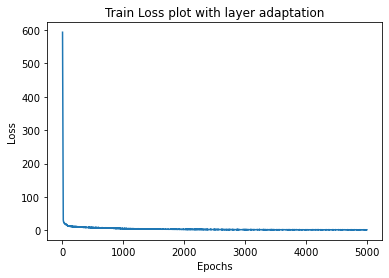

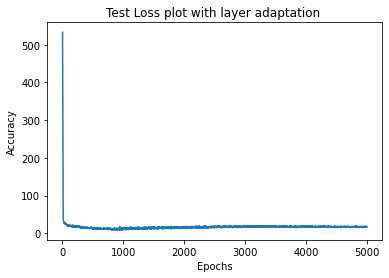

In [8]:
if __name__ == "__main__":     

    trainable=2
    #=== Hyperparameters and Run Options ===#    
    hyperp = Hyperparameters()
    hyperp_new=Hyperparameters_new()
    run_options = RunOptions()
    

    #=== File Names ===#
    file_paths = FilePaths(hyperp, run_options)
    
    #=== Load Data ===#       
    data_train, labels_train,\
    data_test, labels_test,\
    data_input_shape, num_channels, label_dimensions\
    = load_data(file_paths.NN_type, file_paths.dataset, run_options.random_seed) 
    


    
    #for i in range(1,hyperp.num_networks):
    for i in range(1,2):
    #=== Initiate training ===#
        #trainer(hyperp, run_options, file_paths,i) 
        if i>1:
            trainable=2

    
            
        if trainable==2:
        
        
        
            #=== GPU Settings ===#
            os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
            os.environ["CUDA_VISIBLE_DEVICES"] = run_options.which_gpu
    
            #=== Neural Network ===#
            if run_options.use_L1 == 0:
                kernel_regularizer = None
                bias_regularizer = None  
            else:
                kernel_regularizer = tf.keras.regularizers.l1(hyperp.regularization)
                bias_regularizer = tf.keras.regularizers.l1(hyperp.regularization)
            
            
            multiply=0
        
            if multiply==0:

                data_train,new_label,labels_train=create_new(data_train, labels_train,hyperp,hyperp_new, run_options, data_input_shape, label_dimensions,i)
        
            if multiply==1:

                data_train,new_label,labels_train=create_new_multiply(data_train, labels_train,hyperp,hyperp_new, run_options, data_input_shape, label_dimensions,i)
     
        #=== Construct Validation Set and Batches ===# 
            data_and_labels_train, data_and_labels_val, data_and_labels_test,\
            num_data_train, num_data_val, num_data_test,\
            num_batches_train, num_batches_val, num_batches_test,data_and_labels_train_new\
            = form_train_val_test_batches(data_train, labels_train, \
                                      data_test, labels_test, \
                                      hyperp.batch_size, new_label, run_options.random_seed)
        
        
        if i==1 and trainable==2:
            NN = FCLayerwise(hyperp, run_options, data_input_shape, label_dimensions,kernel_regularizer, bias_regularizer)    
            NN._set_inputs( data_train)
        if i>1:
            kernel_regularizer = None
            bias_regularizer = None
            NN = FCLayerwise_new(hyperp_new, run_options, data_input_shape, label_dimensions,kernel_regularizer, bias_regularizer) 
            NN._set_inputs( data_train)
    #=== Training ===#
    #                                 Training                                    #
###############################################################################
        if trainable>2:
            del NN
            NN = Final(hyperp, run_options, data_input_shape, label_dimensions,kernel_regularizer, bias_regularizer,trainable)   
            #NN._set_inputs(data_train)
            NN.load_weights("WEIGHTS"+'/'+"model_weights"+str(1)+str(trainable-1))
            #NN=tf.keras.models.load_model("WEIGHTS"+'/'+"model"+str(1)+str(trainable-1))
        


        if i==1:
            hyperp_n=hyperp
            optimize(hyperp,hyperp_n, run_options, file_paths, NN, data_loss_classification, data_loss_regression, data_and_labels_train, data_and_labels_val, data_and_labels_test, label_dimensions, num_batches_train,data_and_labels_train_new,manifold_classification,hyperp.batch_size,run_options.random_seed,num_data_train,i,data_input_shape,data_train,labels_train,multiply,trainable)   
        
        if i>1:
            hyperp_n=Hyperparameters_new()
            optimize_step(hyperp,hyperp_n, run_options, file_paths, NN, data_loss_classification, data_loss_regression, data_and_labels_train, data_and_labels_val, data_and_labels_test, label_dimensions, num_batches_train,data_and_labels_train_new,manifold_classification_new,hyperp.batch_size,run_options.random_seed,num_data_train,i,data_input_shape,data_train,labels_train,multiply)   
        
        #NN.save("WEIGHTS"+'/'+"model"+str(1)+str(trainable))
        if not os.path.exists("WEIGHTS"):
            os.makedirs("WEIGHTS")
        NN.save_weights("WEIGHTS"+'/'+"model_weights"+str(1)+str(trainable))
        
        if i==1:
            plot_fig(hyperp, run_options, file_paths,i,trainable+1)
            
        if i>1:
            plot_fig(hyperp_new, run_options, file_paths,i,3)
        
        

        
        
        
        
        
        
        
        

In [ ]:
from sklearn.cluster import KMeans
data_train=data_train
new_label=labels_train
Kmean=KMeans(n_clusters=5)
Kmean.fit(data_train)
labels_train_new=Kmean.labels_

In [ ]:
labels_train_new

In [ ]:
hyperp = Hyperparameters()
hyperp_new=Hyperparameters_new()
run_options = RunOptions()
    

    #=== File Names ===#
file_paths = FilePaths(hyperp, run_options)
    
    #=== Load Data ===#       
data_train, labels_train,\
data_test, labels_test,\
data_input_shape, num_channels, label_dimensions= load_data(file_paths.NN_type, file_paths.dataset, run_options.random_seed) 

data_train,new_label,labels_train=create_new(data_train, labels_train,hyperp,hyperp_new, run_options, data_input_shape, label_dimensions,11)
        

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential()
model.add(layers.Dense(5, activation='elu', input_shape=(13,)))
model.add(layers.Dense(5, activation='elu'))
model.add(layers.Dense(1, activation='linear'))
model.summary()

opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_squared_error'])
model.fit(data_train,new_label,batch_size=100,epochs=500,verbose=1)


In [ ]:
model.save("WEIGHTS"+'/'+"model"+str(10))
batch_pred_test = model(data_test)
y_pred_test_add=net_output(hyperp,hyperp_new,data_test, run_options, data_input_shape, label_dimensions,10,batch_pred_test)
batch_pred_test=batch_pred_test+y_pred_test_add
mean_accuracy_test = tf.keras.metrics.Mean()
mean_accuracy_test(data_loss_regression(batch_pred_test, labels_test,label_dimensions))

In [ ]:
mean_accuracy_test = tf.keras.metrics.Mean()
mean_accuracy_test(data_loss_regression(batch_pred_test, labels_test,label_dimensions))

In [ ]:
"WEIGHTS"+'/'+"model_weights"+str(i_val)
hidden_layers_list.insert(0, NoDependency(1))        


In [ ]:
hidden_layers_list[0]

In [ ]:
hidden_layers_list

In [ ]:
len(hidden_layers_list)

In [ ]:
            Network=Final_Network( hyperp,run_options, data_input_shape, label_dimensions) 
        
            Network.load_weights("WEIGHTS"+'/'+"model_weights"+str(2-1)).expect_partial()
    
            y_pred=Network(data_train)


In [ ]:
new_label=tf.reshape(new_label,(len(y_pred),1))

In [ ]:
y_pred

In [ ]:
new_label

In [ ]:
np.multiply(new_label,y_pred)

In [ ]:
ff=data_and_labels_train_new.shuffle(num_data_train,seed=random_seed)
            
data_and_labels_train_new_new = ff.batch(batch_size)
for batch_num, (batch_data_train, batch_labels_train,labels) in data_and_labels_train_new_new.enumerate():
    labels

In [ ]:
x_train_new = batch_data_train[batch_labels_train == 1]


In [ ]:
batch_pred_train,val=NN(x_train_new)
dimension=np.shape(val)
        

length=len(x_train_new)

In [ ]:
new_one=val[1:length]

In [ ]:
sum_val = 0.1*length*dimension[1]*tf.math.reduce_mean(tf.keras.losses.mean_squared_error(new_one, val[0:length-1]))

In [ ]:
    import matplotlib.pyplot as plt
    storage_loss_array=[]
    storage_accuracy_array=[]
    max_hidden_layers=7
    no_epoch=hyperp.num_epochs
    
    for i in range(2,max_hidden_layers):
    
        trainable_hidden_layer_index=i
    
    
        name=file_paths.NN_savefile_name + "_metrics_hl" + str(trainable_hidden_layer_index) +str(1)+ '.csv'


        df_metrics =pd.read_csv(name)

        array_metrics = df_metrics.to_numpy()

        storage_loss_array=np.concatenate((storage_loss_array, array_metrics[:,0]), axis=0)
 
        storage_accuracy_array=np.concatenate((storage_accuracy_array, array_metrics[:,1]), axis=0)
    
    if not os.path.exists("plots"):
        os.makedirs("plots")
#=== Plot and Save Losses===#
    fig_loss = plt.figure()
    x_axis = np.linspace(1, len(storage_loss_array), len(storage_accuracy_array), endpoint = True)
    plt.plot(x_axis, storage_loss_array)
    plt.title('Train Loss plot with layer adaptation' )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0,600)
    plt.xlim(0,150)
    fig_loss.savefig("plots"+'/'+"loss"+str(1)+'.png')


In [ ]:
data_and_labels_train_full = tf.data.Dataset.from_tensor_slices((data_train, labels_train,new_label)).shuffle(num_data_train, seed=random_seed)

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import datasets
kernel_regularizer = tf.keras.regularizers.l1(hyperp.regularization)
bias_regularizer = tf.keras.regularizers.l1(hyperp.regularization)
(data_train, labels_train), (data_test, labels_test) = datasets.cifar10.load_data()
#(data_train, labels_train), (data_test, labels_test) = datasets.mnist.load_data()
#data_train = tf.reshape(data_train, (len(data_train), 28*28))
#data_test = tf.reshape(data_test, (len(data_test), 28*28))
data_train = tf.reshape(data_train, (len(data_train), 32*32*3))
data_test = tf.reshape(data_test, (len(data_test), 32*32*3))
    
label_dimensions = 10
data_input_shape = data_train.shape[1:]

In [ ]:
labels_train=np.squeeze(labels_train,axis=1)

In [ ]:
Network=Final_Network(hyperp, run_options, data_input_shape, label_dimensions,
                      kernel_regularizer, bias_regularizer) 

In [ ]:
Network.load_weights("WEIGHTS"+'/'+"model_weights1")

In [ ]:
num_data_train = len(data_train)
data_and_labels_train_new = data_and_labels_train_full.take(num_data_train)

In [ ]:
ff=data_and_labels_train_new.shuffle(num_data_train,seed=random_seed)
batch_size=100           
data_and_labels_train_new_new = ff.batch(batch_size)

In [ ]:
for batch_num, (batch_data_train, batch_labels_train,labels) in data_and_labels_train_new_new.enumerate():
    labels

In [ ]:
x_train_new = batch_data_train[batch_labels_train == 0]

In [ ]:
(data_train, labels_train), (data_test, labels_test) = datasets.mnist.load_data()
data_train = data_train.reshape(data_train.shape[0], 28, 28, 1)
data_test = data_test.reshape(data_test.shape[0], 28, 28, 1)
label_dimensions = 10
data_input_shape = data_train.shape[1:]

#=== Casting as float32 ===#
data_train = tf.cast(data_train,tf.float32)
labels_train = tf.cast(labels_train, tf.int32)
data_test = tf.cast(data_test, tf.float32)
labels_test = tf.cast(labels_test, tf.int32)
    
#=== Normalize Data ===#
data_train, data_test = data_train/255.0, data_test/255.0
data_train = tf.image.per_image_standardization(data_train) # Linearly scales each image to have mean 0 and variance 1
data_test = tf.image.per_image_standardization(data_test)   # Linearly scales each image to have mean 0 and variance 1

data_train = tf.reshape(data_train, (len(data_train), 28*28))
data_test = tf.reshape(data_test, (len(data_test), 28*28))

num_data_train = len(data_train)
num_data_test = len(data_test)
random_seed=1234
batch_size        = 1000

data_and_labels_train_full = tf.data.Dataset.from_tensor_slices((data_train, labels_train)).shuffle(num_data_train, seed=random_seed)
data_and_labels_test = tf.data.Dataset.from_tensor_slices((data_test, labels_test)).batch(batch_size)
num_batches_test = len(list(data_and_labels_test))

#=== Partitioning Out Validation Set and Constructing Batches ===#
current_num_data_train = num_data_train
num_data_train = int(0.8 * num_data_train)
num_data_val = current_num_data_train - num_data_train
data_and_labels_train_full = tf.data.Dataset.from_tensor_slices((data_train, labels_train)).shuffle(num_data_train, seed=random_seed)
data_and_labels_train = data_and_labels_train_full.take(num_data_train).batch(batch_size)
data_and_labels_val = data_and_labels_train_full.skip(num_data_train).batch(batch_size)    
num_batches_train = len(list(data_and_labels_train))
num_batches_val = len(list(data_and_labels_val))

In [ ]:
(data_train, labels_train), (data_test, labels_test) = datasets.mnist.load_data()
data_train = data_train.reshape(data_train.shape[0], 28, 28, 1)
data_test = data_test.reshape(data_test.shape[0], 28, 28, 1)
label_dimensions = 10
data_input_shape = data_train.shape[1:]

#=== Casting as float32 ===#
data_train = tf.cast(data_train,tf.float32)
labels_train = tf.cast(labels_train, tf.int32)
data_test = tf.cast(data_test, tf.float32)
labels_test = tf.cast(labels_test, tf.int32)
    
#=== Normalize Data ===#
data_train, data_test = data_train/255.0, data_test/255.0
data_train = tf.image.per_image_standardization(data_train) # Linearly scales each image to have mean 0 and variance 1
data_test = tf.image.per_image_standardization(data_test)   # Linearly scales each image to have mean 0 and variance 1

data_train = tf.reshape(data_train, (len(data_train), 28*28))
data_test = tf.reshape(data_test, (len(data_test), 28*28))

num_data_train = len(data_train)
num_data_test = len(data_test)
random_seed=1234
batch_size        = 1000

In [ ]:
labels=tf.one_hot(tf.cast(labels_train,tf.int64), label_dimensions, dtype=tf.float32)

In [ ]:
data_and_labels_train_full = tf.data.Dataset.from_tensor_slices((data_train, labels_train,labels)).shuffle(num_data_train, seed=random_seed)

In [ ]:
data_and_labels_train = data_and_labels_train_full.take(num_data_train).batch(batch_size)
data_and_labels_val = data_and_labels_train_full.skip(num_data_train).batch(batch_size)    
num_batches_train = len(list(data_and_labels_train))
num_batches_val = len(list(data_and_labels_val))

In [ ]:
for batch_num, (batch_data_train, batch_labels_train,labels) in data_and_labels_train.enumerate():
    batch=batch_num
    batch_data_train = batch_data_train
    batch_labels_train=batch_labels_train
    lab=labels

In [ ]:
lab


In [ ]:
y_true = tf.one_hot(tf.cast(labels_train,tf.int64), label_dimensions, dtype=tf.float32)

In [ ]:
y_true

In [ ]:
np.mean(tf.keras.losses.mean_squared_error(new_one, val[0:dimension[0]-1]))

In [ ]:

x_train_new = batch_data_train[batch_labels_train == 1]
batch_pred_train,val=NN(x_train_new)



In [ ]:
y_true = tf.one_hot(tf.cast(y_true,tf.int64), label_dimensions, dtype=tf.float32)

In [ ]:
loss

In [ ]:
np.linalg.norm(val[0]-val[1])